In [1]:
import os 
import glob
import pandas as pd

import cv2
import numpy as np
#Img Augment

#import imgaug as ia
#import imgaug.augmenters as iaa
#from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

from sklearn.model_selection import train_test_split

import torch

import torch.nn as nn
from torch.utils.data import Dataset

from torchsummary import summary

from torchvision import models
from torchvision.utils import make_grid
from torchvision import transforms as T
from sklearn import preprocessing


import matplotlib.patches as patches
import matplotlib.pyplot as plt


from dataload import xml_to_csv,PetData

from tqdm import tqdm


In [2]:
##Loading data
#root_path="D:/Dataset/Pet_Data/"
#root_path="D:/Dataset/Pet_Data/"
root_path="D:/Dataset/Oxford"

img_path=os.path.join(root_path,"images")
annotation_path=os.path.join(root_path,"annotations/xmls")           
annots = glob.glob(annotation_path+"/*.xml")

seed=0
df=xml_to_csv(annots,img_path)
df.head()

## Make Balanced Dataset (To save time, but don't do this in real research!!)
g = df.groupby('target')
balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(),random_state=seed).reset_index(drop=True),))
train, test = train_test_split(balanced_df, test_size=0.2,random_state=seed)

BATCH_SIZE = 1
train_ds = PetData(train, train=True)
valid_ds= PetData(test, train=True)
def collate_fn(batch):
    return zip(*batch)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn,shuffle=False)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn)

In [3]:
from collections import Counter
print(Counter(train.target))
from collections import Counter
print(Counter(test.target))

Counter({1: 958, 0: 942})
Counter({0: 246, 1: 230})


## Model Workflow
How R-CNN works can be summarized as follows:

1. *Pre-train a CNN* network on image classification tasks; for example, VGG or ResNet trained on ImageNet dataset. The classification task involves N classes.
    NOTE: You can find a pre-trained AlexNet in Caffe Model Zoo. I don’t think you can find it in Tensorflow, but Tensorflow-slim model library provides pre-trained ResNet, VGG, and others.

2. Propose category-independent regions of interest by selective search (~2k candidates per image). Those regions may contain target objects and they are of different sizes.
3. Region candidates are warped to have a fixed size as required by CNN.
4. Continue fine-tuning the CNN on warped proposal regions for K + 1 classes; The additional one class refers to the background (no object of interest). In the fine-tuning stage, we should use a much smaller learning rate and the mini-batch oversamples the positive cases because most proposed regions are just background.
5. Given every image region, one forward propagation through the CNN generates a feature vector. This feature vector is then consumed by a binary SVM trained for each class independently.
6. The positive samples are proposed regions with IoU (intersection over union) overlap threshold >= 0.3, and negative samples are irrelevant others.
To reduce the localization errors, a regression model is trained to correct the predicted detection window on bounding box correction offset using CNN features.

## 1. Pretrain a CNN network on image classification

In [4]:
import torch
from torchvision import models

#We used pretrained network from torch
mobilenet = models.mobilenet_v2(pretrained=True)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
                              
print(f'Num of parameters: {count_parameters(mobilenet)}')


Num of parameters: 3504872


## 2. Selective Search from [AlpacaDB](https://github.com/AlpacaDB/selectivesearch)
### In actual R-CNN, they extracted 2k proposals but let's skip this detail...
Explanation to be added

In [5]:
from utills import ssearch,misc

In [6]:
img_lbl, regions = ssearch.selective_search(train_ds[0][0].numpy().transpose(1,2,0), scale=100, sigma=0.8, min_size=20)
print(f"Possibled Regions:{len(regions)}")

Possibled Regions:970


### Visualizing proposed regions

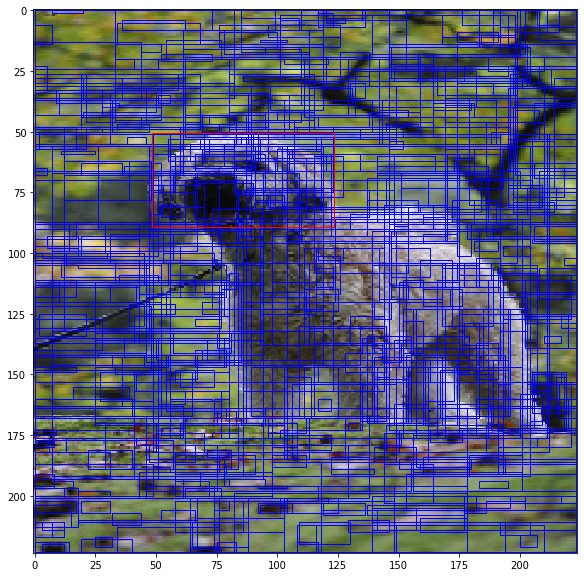

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_lbl[:,:,0:3]*0.5+0.5)
for i in regions:
    rect=i['rect']
    xy=rect[0],rect[1]
    width=rect[2]
    height=rect[3]
    
    ax.add_patch(
     patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = 'blue',
        fill=False ) )
for bbox in train_ds[0][1]:
    xy=(bbox[0],bbox[1])
    width=bbox[2]-bbox[0]
    height=bbox[3]-bbox[1]

    ax.add_patch(
     patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = 'red',
        fill=False ) )
plt.show()

## 3. Region candidates are warped to have a fixed size as required by CNN
## 4. Continue fine-tuning the CNN on warped proposal regions for K + 1 classes; The additional one class refers to the background (no object of interest). In the fine-tuning stage, we should use a much smaller learning rate and the mini-batch oversamples the positive cases because most proposed regions are just background.

In [8]:
def create_label(proposed_regions,bboxes):
    ''' 
    Adding Labelling to the proposed regions, if iou of prposed_region and actual bounding box of label 'x' is larger than the threshold, we label it as 'x' 
    
    proposed_regions:output of selective_search
    bboxes: ground truth bbox of original img
    '''
    from metrics import iou
    iou_threshold=0.6
    for region in proposed_regions:
        max_iou=0
        region['labels']=-1
        region_tensor=torch.tensor((region['rect'][0],region['rect'][1],region['rect'][0]+region['rect'][2],region['rect'][1]+region['rect'][3]))
        for bbox in bboxes:
            box_tensor=torch.tensor((bbox[0],bbox[1],bbox[2],bbox[3]))
            cur_iou=iou.torch_getIOU(region_tensor,box_tensor)
            if cur_iou>max_iou:
                max_iou=cur_iou
                if max_iou>iou_threshold:
                    region['labels']=bbox[4].item()    
                
        #region['iou']=max_iou
    return proposed_regions

def balance_df(proposed_regions):
    '''
    Rather than we oversample, we tried undersampling the background cases,  
    (*this is only for possible for this dataset which always and only have one of its classes (dog,cat) in the image)
    '''
    regions_df=pd.DataFrame.from_dict(proposed_regions)
 #   g = proposed_regions.groupby('labels')
  #  g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
#    
    def sampling_k_elements(group, k=1):
        if len(group) < k:
            return group
        return group.sample(k)
    #return g
    g = regions_df.groupby('labels').apply(sampling_k_elements).reset_index(drop=True)
    
    return g

In [10]:
#We create another dataset class to be used in training which stores the proposed region dataset
class Sub_region(Dataset):
    def __init__(self, df,img):
        self.src_img=img
        self.df=df
        self.resize=nn.Upsample((224,224))
        self.transforms=T.ToPILImage()
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        label=self.df.iloc[idx]['labels']
        rect=self.df.iloc[idx]['rect']
        x1=rect[0]
        y1=rect[1]
        x2=rect[2]+x1+1
        y2=rect[3]+y1+1
        img=self.resize(self.src_img[:,y1:y2,x1:x2].unsqueeze(0))*0.5+0.5
        return self.transforms(img.squeeze(0)),label
        #return img.squeeze(0),label


In [11]:
'''
save_root_path="D:/Dataset/Oxford/region_img"

train_df=None
valid_df=None
num=0

for img_batch_idx,(img_tuple,bbox_tuple) in tqdm(enumerate(train_dl)):
    acc_regions=None
    avg_tloss_pimage=0
    for img,bbox in zip(img_tuple,bbox_tuple):  

        #Current selective search only works for one_single,
        #so batch_size of original dataset is 1... 
        #which means tuple has only length of 1
        #regions proposal
        img_lbl, regions = ssearch.selective_search(img.numpy().transpose(1,2,0), scale=100, sigma=0.8, min_size=20)

        regions=create_label(regions,bbox)
        pre_length=len(regions)

        #balancing regions labels
        regions=balance_df(regions)
        post_length=(len(regions))

        #If no true ground_true region is proposed we skip
        if pre_length ==post_length: 
            break
        acc_regions=0


        #Create Dataset of proposed regions
        region_ds=Sub_region(regions,img)


        for idx,(region_img,label) in enumerate(region_ds):

            filename_change = str(num).zfill(5) + ".jpg"
            region_data=dict()
            region_data['filename']=filename_change
            region_data['label']=label
            if train_df is None:

                train_df=pd.DataFrame([[filename_change,label]],columns=["filename","labels"])
            else:
                train_df=train_df.append(pd.DataFrame([[filename_change,label]],columns=["filename","labels"]))
                region_img.save(os.path.join(save_root_path,"train",filename_change), "JPEG")
            num=num+1
train_df.to_csv("train_region_.csv",index=False)

for img_batch_idx,(img_tuple,bbox_tuple) in tqdm(enumerate(valid_dl)):
    acc_regions=None
    avg_tloss_pimage=0
    for img,bbox in zip(img_tuple,bbox_tuple):  

        #Current selective search only works for one_single,
        #so batch_size of original dataset is 1... 
        #which means tuple has only length of 1

        #regions proposal
        img_lbl, regions = ssearch.selective_search(img.numpy().transpose(1,2,0), scale=100, sigma=0.8, min_size=20)

        regions=create_label(regions,bbox)
        pre_length=len(regions)

        #balancing regions labels
        regions=balance_df(regions)
        post_length=(len(regions))

        #If no true ground_true region is proposed we skip
        if pre_length ==post_length: 
            break
        acc_regions=0


        #Create Dataset of proposed regions
        region_ds=Sub_region(regions,img)


        for idx,(region_img,label) in enumerate(region_ds):

            filename_change = str(num).zfill(5) + ".jpg"
            region_data=dict()
            region_data['filename']=filename_change
            region_data['label']=label
            if valid_df is None:

                valid_df=pd.DataFrame([[filename_change,label]],columns=["filename","labels"])
            else:
                valid_df=valid_df.append(pd.DataFrame([[filename_change,label]],columns=["filename","labels"]))
                region_img.save(os.path.join(save_root_path,"valid",filename_change), "JPEG")
            num=num+1
valid_df.to_csv("valid_region.csv_",index=False)
'''
print()

In [12]:
train_data=pd.read_csv("train_region_.csv")
valid_data=pd.read_csv("valid_region.csv")

In [14]:
from collections import Counter

In [16]:
#We oversamples the positive cases because we have lots of background case
Counter(train_data.labels)

Counter({-1.0: 1900, 0.0: 605, 1.0: 602})

In [17]:
max_size = train_data['labels'].value_counts().max()
lst = [train_data]

for class_index, group in train_data.groupby('labels'):
    lst.append(group.sample(max_size-len(group), replace=True))
train_data = pd.concat(lst)
train_data=train_data.reset_index()

In [18]:
Counter(train_data.labels)

Counter({-1.0: 1900, 0.0: 1900, 1.0: 1900})

In [19]:
from PIL import Image

class Sub_region_train(Dataset):
    def __init__(self, df,base_path,train=True):
        self.df=df
        self.base_path=base_path
        if train:
            self.transforms=T.Compose([
                 T.RandomHorizontalFlip(),
                T.RandomRotation(10),
                T.ToTensor(),

                T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),

            ])
        else:
            self.transforms=T.Compose([
            T.ToTensor(),
            T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),

            ])
        self.le= preprocessing.LabelEncoder()
        self.le=self.le.fit([-1,0,1])
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
       # print(self.df.filename[idx])
       # img=cv2.imread(os.path.join(self.base_path,self.df.filename[idx]))
     #   img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=Image.open(os.path.join(self.base_path,self.df.filename[idx]))
        img=self.transforms(img)
        
        return img, self.le.transform([self.df.labels[idx]])[0]
        
        

In [20]:
train_region_ds=Sub_region_train(train_data,"D:/Dataset/Oxford/region_img/train")
valid_region_ds=Sub_region_train(valid_data,"D:/Dataset/Oxford/region_img/valid",train=False)

train_regions_dl =torch.utils.data.DataLoader(train_region_ds, batch_size=64,shuffle=True,drop_last=True)
valid_region_dl =torch.utils.data.DataLoader(valid_region_ds, batch_size=64,shuffle=False,drop_last=True)


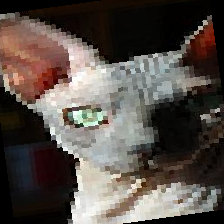

In [29]:
T.ToPILImage()(train_region_ds[4][0]*0.5+0.5)


In [34]:
import torch.optim as optim

## Finetuning 

model = models.alexnet(pretrained=True)
model.classifier[6]=nn.Linear(4096,3)
#freeze_some_part
for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
                              
print(f'Num of parameters: {count_parameters(model)}')

device='cuda'
model.to(device)
epochs=50
# [-1: background 0: cat, 1: dog]




Num of parameters: 54546435


In [35]:
config_=dict()
config_["lr"]=5e-4
config_["crit"]=nn.CrossEntropyLoss()
config_["optim"]=optim.Adam(model.parameters(),lr=config_["lr"])
config_["save_dir"]="models/"
config_["epochs"]=200
config_["train_log"]=[]
config_["valid_log"]=[]
config_["train_acc_log"]=[]
config_["valid_acc_log"]=[]
config_["log_interval"]=100
config_["device"]="cuda"
config_["accuracy"]=True

def train(config,train_dl,valid_dl,model):
    '''
    config.optimizer: Training optimizer eg) Adam,SGD....
    config.criterion: Loss eg) CrossEntropy, 
    config.lr: learning_rate
    train_dl,valid_dl: Dataloader
    model: target model
    save_path
    '''
    model.to(config["device"])
    
    for epoch in range(config["epochs"]):
        print()
        print(f'Epochs : {epoch+1}')
        model.train()
        avg_train_loss=0
        correct=0
        total=0
        for batch_idx,(img,label) in enumerate(train_dl):
            #Zero_grad_Optimizer
            config["optim"].zero_grad()
            img=img.to(config["device"])
            label=label.to(config["device"])
            output=model(img)
            
            #Measure Loss
            loss=config["crit"](output,label)
            loss.backward()
            
            if config["accuracy"]:
                _, predicted = torch.max(output.data, 1)
                total+=label.size()[0]
                correct += (predicted == label).sum().item()
            
            #Update Parameters
            config["optim"].step()
            avg_train_loss+=loss.item()
            if batch_idx % config["log_interval"]==0:
                config["train_log"].append(avg_train_loss/(batch_idx+1))
                config["train_acc_log"].append(correct/(total))
                print()
                print(f"Batch {batch_idx+1}/{len(train_dl)} Loss: {loss.item()}")
                print(f"Accuracy {correct/(total)}")
        model.eval()
        
        valid_loss=0
        correct=0
        total=0
        
        for batch_idx,(img,label) in enumerate(valid_dl):
            
            img=img.to(config["device"])
            label=label.to(config["device"])
            
            output=model(img)
            #Measure Loss
            loss=config["crit"](output,label)
        
            valid_loss+=loss.item()

            if config["accuracy"]:
                _, predicted = torch.max(output.data, 1)
                total+=label.size()[0]
                correct += (predicted == label).sum().item()
        avg_valid_loss=valid_loss/(len(valid_dl))
        config["valid_log"].append(avg_valid_loss)

        
        config["valid_acc_log"].append(correct/total)
        print()
        print(f'Validation_Loss: {config["valid_log"][-1]}')
        print(f'Validation_Acc: {config["valid_acc_log"][-1]}')
        
        try:
            if max(config["valid_acc_log"][0:-1]) < (correct/total):
                print()
                print('Validation Result is better, saving the new model')
                torch.save(model.state_dict(), config["save_dir"]+f"epoch_{epoch}")
        except:
            "First Epoch"
            continue
        
    return config,model
            

In [36]:

config_,model=train(config_,train_regions_dl,valid_region_dl,model)


Epochs : 1

Batch 1/89 Loss: 1.2150729894638062
Accuracy 0.359375

Validation_Loss: 0.34738832024427563
Validation_Acc: 0.890625

Epochs : 2

Batch 1/89 Loss: 0.32229211926460266
Accuracy 0.84375

Validation_Loss: 0.3947194436421761
Validation_Acc: 0.8786057692307693

Epochs : 3

Batch 1/89 Loss: 0.3592783808708191
Accuracy 0.90625

Validation_Loss: 0.3236458760041457
Validation_Acc: 0.8930288461538461

Validation Result is better, saving the new model

Epochs : 4

Batch 1/89 Loss: 0.2127978354692459
Accuracy 0.9375

Validation_Loss: 0.2891425731090399
Validation_Acc: 0.9038461538461539

Validation Result is better, saving the new model

Epochs : 5

Batch 1/89 Loss: 0.11875879019498825
Accuracy 0.9375

Validation_Loss: 0.4307499917653891
Validation_Acc: 0.8918269230769231

Epochs : 6

Batch 1/89 Loss: 0.22694262862205505
Accuracy 0.9375

Validation_Loss: 0.2933553892832536
Validation_Acc: 0.9134615384615384

Validation Result is better, saving the new model

Epochs : 7

Batch 1/89 Los

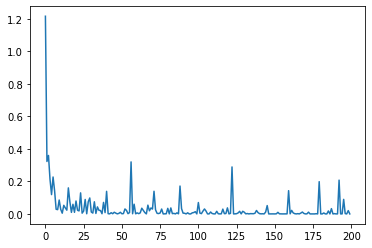

In [37]:
plt.plot(config_["train_log"])

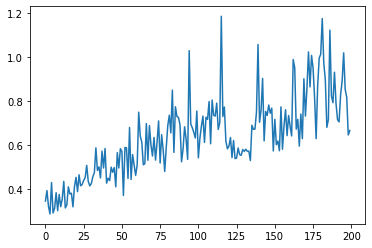

In [38]:
plt.plot(config_["valid_log"])

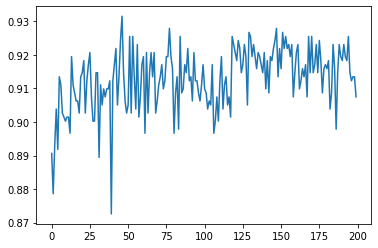

In [39]:
plt.plot(config_["valid_acc_log"])

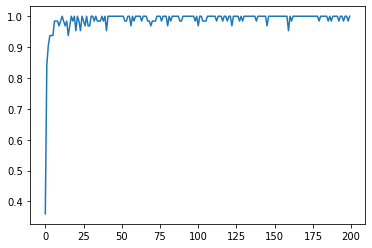

In [40]:
plt.plot(config_["train_acc_log"])